# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [9]:
import numpy as np
import cv2
#from scipy.misc import imread, imresize
import datetime
import os
from skimage import io
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [10]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [11]:
print("Done")

Done


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [12]:

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

train_path = 'Project_data/train'
val_path = 'Project_data/val' #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:

def generator(source_path, folder_list, batch_size, f, y, z):
        print('Source path = ', source_path, '; batch size =', batch_size)
    
        #img_idx = np.round(np.linspace(0,29,int(f)).astype(int)
        img_idx = np.round(np.linspace(0,29,f)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data = np.zeros((batch_size,len(img_idx),y,z,3))
                batch_labels = np.zeros((batch_size,5))
                for folder in range(batch_size):
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                    for idx,item in enumerate(img_idx):
                        image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        image_resized= resize(image, (y, z,3), anti_aliasing=False)
                                             
                                             
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                                             
                                             
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data = np.zeros((remaining_seq,len(img_idx),y,z,3))
                batch_labels = np.zeros((remaining_seq,5))
                for folder in range(remaining_seq):
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*remaining_seq)].split(';')[0])
                    for idx,item in enumerate(img_idx):
                        image = io.imread(source_path+'/'+ t[folder + (batch*remaining_seq)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        image_resized=resize(image, (y, z,3),anti_aliasing=False)
                        
                                      
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                    batch_labels[folder, int(t[folder + (batch*remaining_seq)].strip().split(';')[2])] = 1
                    
                yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.regularizers import l2

In [15]:
class Models():
    @classmethod
    def cnn_1(cls, input_shape):
        
        nb_dense = [256]
        nb_filters = [8,16,32,64]
        
        model = Sequential()
        model.add(Conv3D(nb_filters[0],(3,3,3),padding='same',use_bias=False,input_shape= input_shape)) #(16,96,96,3)
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))


        model.add(Conv3D(nb_filters[1],(3,3,3),padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[2], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[3], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())

        model.add(Dense(nb_dense[0],use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(.5))
        
        model.add(Dense(5,activation='softmax'))
        
        return model
    
    @classmethod
    def cnn_2(cls, input_shape):
        
        nb_dense = [256]
        nb_filters = [8,16,32,64,128]
        
        model = Sequential()
        model.add(Conv3D(nb_filters[0],(3,3,3),padding='same',use_bias=False,input_shape= input_shape)) #(16,96,96,3)
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))


        model.add(Conv3D(nb_filters[1],(3,3,3),padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[2], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[3], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[4], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())

        model.add(Dense(nb_dense[0],use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(.5))
        
        model.add(Dense(5,activation='softmax'))
        
        return model
    
    @classmethod
    def conv_l2(cls, input_shape):
        nb_dense = [256]
        nb_filters = [8,16,32,64,128]
        
        model = Sequential()
        model.add(Conv3D(nb_filters[0],(3,3,3),padding='same',use_bias=False,input_shape= input_shape)) #(16,96,96,3)
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))


        model.add(Conv3D(nb_filters[1],(3,3,3),padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[2], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[3], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[4], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())

        model.add(Dense(256,kernel_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        
        model.add(Dense(5,activation='softmax'))
        
        return model
    
    @classmethod
    def conv_Increasedl2(cls, input_shape):
        nb_dense = [256]
        nb_filters = [8,16,32,64,128]
        
        model = Sequential()
        model.add(Conv3D(nb_filters[0],(3,3,3),padding='same',use_bias=False,input_shape= input_shape)) #(16,96,96,3)
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))


        model.add(Conv3D(nb_filters[1],(3,3,3),padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[2], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[3], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[4], (3,3,3), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())

        model.add(Dense(256,kernel_regularizer=l2(0.035)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        
        model.add(Dense(5,activation='softmax'))
        
        return model
    
    @classmethod
    def conv_lstm_gru(cls, input_shape):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape= input_shape))
        model.add(TimeDistributed(BatchNormalization()))

        model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Conv2D(32, (2,2),padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.3))
                  
        model.add(TimeDistributed(Conv2D(64, (2,2),padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Flatten()))

        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))


        model.add(GRU(128, return_sequences=False))
        model.add(Dense(5, activation='softmax'))
        
        return model
    
    @classmethod
    def conv_lstm(cls, input_shape):
    
        model = Sequential()

        model.add(TimeDistributed(Conv2D(8, (7, 7), strides=(2, 2),
            activation='relu', padding='same'), input_shape=input_shape))
        model.add(TimeDistributed(Conv2D(8, (3,3),
            kernel_initializer="he_normal", activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(16, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(16, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(32, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(64, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(0.5))
        model.add(LSTM(256, return_sequences=False, dropout=0.5))
        model.add(Dense(5, activation='softmax'))
        
        return model
        
    @classmethod
    def conv_lstm_gru_updated(cls, input_shape):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape= input_shape))
        model.add(TimeDistributed(BatchNormalization()))

        model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.15))

        model.add(TimeDistributed(Conv2D(32, (2,2),padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.15))
                  
        model.add(TimeDistributed(Conv2D(64, (2,2),padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.15))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(Dense(64, kernel_regularizer=l2(0.01), activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.15))

        model.add(TimeDistributed(Flatten()))
        
        model.add(Dense(256,kernel_regularizer=l2(0.035)))
        model.add(GRU(128, return_sequences=False))
        model.add(Dense(5, activation='softmax'))
        
        return model
    
    @classmethod
    def conv_rnn(cls, input_shape):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(8, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape= input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.3))

        model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.25))

        model.add(TimeDistributed(Conv2D(32, (2,2),padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(Dropout(0.6))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(Dense(64, kernel_regularizer=l2(0.01), activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128, kernel_regularizer=l2(0.01), activation='relu'))
        model.add(Dropout(0.5))

        model.add(GRU(128, return_sequences=False))
        model.add(Dense(5, activation='softmax'))
        
        return model
        
    @classmethod
    def cnn_3(cls, input_shape):

        nb_dense = [256]
        nb_filters = [8,16,32,64]
        
        model = Sequential()
        model.add(Conv3D(nb_filters[0],(3,3,3),padding='same',use_bias=False,input_shape= input_shape)) #(16,96,96,3)
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Conv3D(nb_filters[1],(3,3,3),padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[2], (2,2,2), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(nb_filters[3], (2,2,2), padding='same',use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(5,activation='softmax'))
        
        return model
    

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [20]:
def training(batch_size, num_epochs, model, train_generator, val_generator, name = 'model', optimiser=None):
    
    curr_dt_time = datetime.datetime.now()

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    num_epochs = num_epochs # choose the number of epochs
    print ('# epochs =', num_epochs)
    
    
    if optimiser == None:
        optimiser = Adam(lr = 0.001) 
    else:
        optimiser = optimizers.Adam(lr= 0.0002)

    
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()


    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    #filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    filepath = model_name + 'model-'+name+'.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, cooldown=1, verbose=1) # write the REducelronplateau code here

    callbacks_list = [checkpoint, LR]
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history
    


In [21]:
# list all data in history
import matplotlib.pyplot as plt
def loss(history):
    print(history.history.keys())

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



#### Hyper Parameter Tuning

In [17]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


In [10]:
from keras import optimizers
from keras.callbacks import *

# range of learning rates to tune
hyper_parameters_for_lr = [0.1, 0.01, 0.001]

# callback to append loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}
input_shape = (30,96,96, 3)
batch_size = 5
num_epochs = 10

model_def = Models()

num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=1, cooldown=1, verbose=1)
    
# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    optimiser = Adam(lr)
    
    # model and generators
    model = model_def.cnn_1(input_shape)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    training_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
    validation_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    
    model.fit_generator(training_generator, steps_per_epoch=steps_per_epoch, epochs=3, verbose=1, 
                    callbacks=[history, LR], validation_data=validation_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.1  ========================================
Source path =  Project_data/val ; batch size = 5
Source path =  Project_data/train ; batch size = 5
Epoch 1/3


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 257s 2s/step - loss: 5.7403 - categorical_accuracy: 0.2877 - val_loss: 3.8691 - val_categorical_accuracy: 0.2400
Epoch 2/3
133/133 [==============================] - 131s 985ms/step - loss: 1.5507 - categorical_accuracy: 0.2737 - val_loss: 1.4810 - val_categorical_accuracy: 0.3200
Epoch 3/3
133/133 [==============================] - 142s 1s/step - loss: 1.5653 - categorical_accuracy: 0.2587 - val_loss: 1.5005 - val_categorical_accuracy: 0.3500

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.09000000134110452.


========================================   Checking for LR=0.01  ========================================
Source path =  Project_data/val ; batch size = 5
Source path =  Project_data/trainEpoch 1/3
 ; batch size = 5
133/133 [==============================] - 134s 1s/step - loss: 1.9368 - categorical_accuracy: 0.3378 - val_loss: 6.2855 - val_categorical_accuracy: 0.2400
Epoch 2/3
133/133 [==============================] - 105

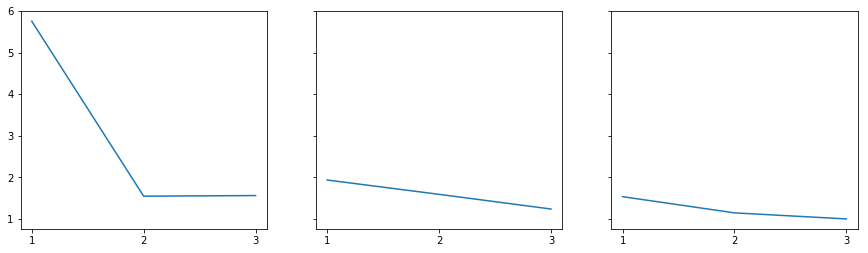

In [11]:
# plot loss history for each value of hyperparameter with ReduceLROnPlateau enabled for patience=1 and factor=0.9
import matplotlib.pyplot as plt
%matplotlib inline
f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

LR=0.001 seems to exhibit lower loss and high accuracy on train and validation data

## Model 1

In [25]:

model_def = Models()
input_shape = (30,96,96, 3)
batch_size = 5
num_epochs = 10

model = model_def.cnn_1(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_1_b5_e10_f30_i96')

# training sequences = 663
# validation sequences = 100
# epochs = 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 30, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_61 (Batc (None, 30, 96, 96, 8)     32        
_________________________________________________________________
activation_61 (Activation)   (None, 30, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 30, 48, 48, 8)     0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 30, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_62 (Batc (None, 30, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 118s 886ms/step - loss: 1.4841 - categorical_accuracy: 0.4702 - val_loss: 1.6549 - val_categorical_accuracy: 0.4800

Epoch 00001: val_loss improved from inf to 1.65485, saving model to model_init_2020-11-0713_52_56.598678/model-cnn_1_b5_e10.h5
Epoch 2/10
133/133 [==============================] - 98s 740ms/step - loss: 1.0514 - categorical_accuracy: 0.6100 - val_loss: 1.4388 - val_categorical_accuracy: 0.5600

Epoch 00002: val_loss improved from 1.65485 to 1.43876, saving model to model_init_2020-11-0713_52_56.598678/model-cnn_1_b5_e10.h5
Epoch 3/10
133/133 [==============================] - 106s 795ms/step - loss: 1.0452 - categorical_accuracy: 0.6165 - val_loss: 1.3998 - val_categorical_accuracy: 0.5800

Epoch 00003: val_loss improved from 1.43876 to 1.39979, saving model to model_init_2020-11-0713_52_56.598678/model-cnn_1_b5_e10.h5
Epoch 4/10
133/133 [==============================] - 106s 793ms/step - loss: 0.9049 - categorical_accuracy: 0

In [26]:
# write up

model_def = Models()
input_shape = (30,96,96, 3)
batch_size = 5
num_epochs = 15

model = model_def.cnn_1(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_1_b5_e15_f30_i96')

# training sequences = 663
# validation sequences = 100
# epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 30, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_66 (Batc (None, 30, 96, 96, 8)     32        
_________________________________________________________________
activation_66 (Activation)   (None, 30, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 30, 48, 48, 8)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 30, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_67 (Batc (None, 30, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 114s 860ms/step - loss: 1.6734 - categorical_accuracy: 0.3935 - val_loss: 2.2898 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 2.28977, saving model to model_init_2020-11-0714_10_49.285766/model-cnn_1_b5_e15.h5
Epoch 2/15
133/133 [==============================] - 106s 796ms/step - loss: 1.2539 - categorical_accuracy: 0.5163 - val_loss: 2.6717 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss did not improve from 2.28977
Epoch 3/15
133/133 [==============================] - 104s 786ms/step - loss: 1.0500 - categorical_accuracy: 0.6005 - val_loss: 2.1823 - val_categorical_accuracy: 0.3800

Epoch 00003: val_loss improved from 2.28977 to 2.18226, saving model to model_init_2020-11-0714_10_49.285766/model-cnn_1_b5_e15.h5
Epoch 4/15
133/133 [==============================] - 109s 817ms/step - loss: 0.8892 - categorical_accuracy: 0.6667 - val_loss: 0.8167 - val_categorical_accuracy: 0.6700

Epoch 00004: val_l

In [28]:

model_def = Models()
input_shape = (30,96,96, 3)
batch_size = 5
num_epochs = 30

model = model_def.cnn_1(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_1_b5_e30_f30_i96')

# training sequences = 663
# validation sequences = 100
# epochs = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 30, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_76 (Batc (None, 30, 96, 96, 8)     32        
_________________________________________________________________
activation_76 (Activation)   (None, 30, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 30, 48, 48, 8)     0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 30, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_77 (Batc (None, 30, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 125s 941ms/step - loss: 1.6383 - categorical_accuracy: 0.4145 - val_loss: 2.3521 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 2.35206, saving model to model_init_2020-11-0715_08_43.781435/model-cnn_1_b5_e30.h5
Epoch 2/30
133/133 [==============================] - 97s 732ms/step - loss: 1.1978 - categorical_accuracy: 0.5388 - val_loss: 3.3086 - val_categorical_accuracy: 0.3300

Epoch 00002: val_loss did not improve from 2.35206
Epoch 3/30
133/133 [==============================] - 103s 774ms/step - loss: 0.9780 - categorical_accuracy: 0.6351 - val_loss: 0.8887 - val_categorical_accuracy: 0.6700

Epoch 00003: val_loss improved from 2.35206 to 0.88869, saving model to model_init_2020-11-0715_08_43.781435/model-cnn_1_b5_e30.h5
Epoch 4/30
133/133 [==============================] - 104s 784ms/step - loss: 0.8636 - categorical_accuracy: 0.6742 - val_loss: 1.7827 - val_categorical_accuracy: 0.5100

Epoch 00004: val_lo

In [27]:
# For write up 2

model_def = Models()
input_shape = (16,96,96, 3)
batch_size = 10
num_epochs = 30

model = model_def.cnn_1(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_1_b10_e30_f16_i96')

# training sequences = 663
# validation sequences = 100
# epochs = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 16, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_71 (Batc (None, 16, 96, 96, 8)     32        
_________________________________________________________________
activation_71 (Activation)   (None, 16, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 16, 48, 48, 8)     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 16, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 56s 842ms/step - loss: 1.4845 - categorical_accuracy: 0.4622 - val_loss: 3.9344 - val_categorical_accuracy: 0.2900

Epoch 00001: val_loss improved from inf to 3.93443, saving model to model_init_2020-11-0714_38_33.173728/model-cnn_1_b10_e30.h5
Epoch 2/30
67/67 [==============================] - 55s 817ms/step - loss: 1.0438 - categorical_accuracy: 0.6035 - val_loss: 2.2907 - val_categorical_accuracy: 0.4700

Epoch 00002: val_loss improved from 3.93443 to 2.29071, saving model to model_init_2020-11-0714_38_33.173728/model-cnn_1_b10_e30.h5
Epoch 3/30
67/67 [==============================] - 56s 840ms/step - loss: 0.7560 - categorical_accuracy: 0.7159 - val_loss: 1.1699 - val_categorical_accuracy: 0.5900

Epoch 00003: val_loss improved from 2.29071 to 1.16990, saving model to model_init_2020-11-0714_38_33.173728/model-cnn_1_b10_e30.h5
Epoch 4/30
67/67 [==============================] - 55s 827ms/step - loss: 0.5649 - categorical_accuracy: 0.7865 - 

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

#### Model 2

In [9]:
# Write up

model = Models()
input_shape = (16,96,96, 3)
batch_size = 5
num_epochs = 15

model = model.cnn_2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_2_b5_e15_f16_i96')

# training sequences = 663
# validation sequences = 100
# epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 96, 96, 8)     32        
_________________________________________________________________
activation_1 (Activation)    (None, 16, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 48, 48, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 172s 1s/step - loss: 1.7174 - categorical_accuracy: 0.3724 - val_loss: 3.1363 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 3.13631, saving model to model_init_2020-11-0716_25_45.533320/model-cnn_2_b5_e15.h5
Epoch 2/15
133/133 [==============================] - 72s 538ms/step - loss: 1.3991 - categorical_accuracy: 0.4581 - val_loss: 3.0326 - val_categorical_accuracy: 0.3300

Epoch 00002: val_loss improved from 3.13631 to 3.03259, saving model to model_init_2020-11-0716_25_45.533320/model-cnn_2_b5_e15.h5
Epoch 3/15
133/133 [==============================] - 71s 534ms/step - loss: 1.1855 - categorical_accuracy: 0.5268 - val_loss: 2.0540 - val_categorical_accuracy: 0.5100

Epoch 00003: val_loss improved from 3.03259 to 2.05397, saving model to model_init_2020-11-0716_25_45.533320/model-cnn_2_b5_e15.h5
Epoch 4/15
133/133 [==============================] - 72s 544ms/step - loss: 1.1420 - categorical_accuracy: 0.5679

In [11]:
model = Models()
input_shape = (16,120,120, 3)
batch_size = 10
num_epochs = 30

model = model.cnn_2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_2_b5_e15_f16_i120')

# training sequences = 663
# validation sequences = 100
# epochs = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 16, 120, 120, 8)   648       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 16, 60, 60, 8)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 16, 60, 60, 16)    3456      
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 60, 60, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 66s 988ms/step - loss: 1.4439 - categorical_accuracy: 0.4602 - val_loss: 2.1220 - val_categorical_accuracy: 0.4200

Epoch 00001: val_loss improved from inf to 2.12200, saving model to model_init_2020-11-0717_04_41.711857/model-cnn_2_b5_e15.h5
Epoch 2/30
67/67 [==============================] - 63s 940ms/step - loss: 1.0441 - categorical_accuracy: 0.6070 - val_loss: 2.0331 - val_categorical_accuracy: 0.5000

Epoch 00002: val_loss improved from 2.12200 to 2.03307, saving model to model_init_2020-11-0717_04_41.711857/model-cnn_2_b5_e15.h5
Epoch 3/30
67/67 [==============================] - 60s 891ms/step - loss: 0.9232 - categorical_accuracy: 0.6607 - val_loss: 1.5086 - val_categorical_accuracy: 0.5700

Epoch 00003: val_loss improved from 2.03307 to 1.50857, saving model to model_init_2020-11-0717_04_41.711857/model-cnn_2_b5_e15.h5
Epoch 4/30
67/67 [==============================] - 60s 891ms/step - loss: 0.7802 - categorical_accuracy: 0.7144 - val

#### Model 3

In [12]:
# Model 3 - write up

modell = Models()
input_shape = (30,96,96, 3)
batch_size = 5
num_epochs = 20

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b5_e20_f_30_i96')

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 96, 96, 8)     32        
_________________________________________________________________
activation_19 (Activation)   (None, 30, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 30, 48, 48, 8)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 30, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_20 (Batc (None, 30, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 190s 1s/step - loss: 4.8142 - categorical_accuracy: 0.3353 - val_loss: 3.4110 - val_categorical_accuracy: 0.5300

Epoch 00001: val_loss improved from inf to 3.41103, saving model to model_init_2020-11-0717_37_18.535712/model-conv_l2_b5_e20_i96.h5
Epoch 2/20
133/133 [==============================] - 108s 814ms/step - loss: 3.1204 - categorical_accuracy: 0.4015 - val_loss: 3.0501 - val_categorical_accuracy: 0.3100

Epoch 00002: val_loss improved from 3.41103 to 3.05011, saving model to model_init_2020-11-0717_37_18.535712/model-conv_l2_b5_e20_i96.h5
Epoch 3/20
133/133 [==============================] - 97s 728ms/step - loss: 2.4732 - categorical_accuracy: 0.4561 - val_loss: 1.8903 - val_categorical_accuracy: 0.7000

Epoch 00003: val_loss improved from 3.05011 to 1.89031, saving model to model_init_2020-11-0717_37_18.535712/model-conv_l2_b5_e20_i96.h5
Epoch 4/20
133/133 [==============================] - 100s 750ms/step - loss: 1.8601 - categori

In [24]:
# Model 3 - L2b10 - Best model

modell = Models()
input_shape = (20,96,96, 3)
batch_size = 10
num_epochs = 20

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b10_e20_f20_i96')
#loss_plot(history)

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 20, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_21 (Batc (None, 20, 96, 96, 8)     32        
_________________________________________________________________
activation_25 (Activation)   (None, 20, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 20, 48, 48, 8)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 20, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_22 (Batc (None, 20, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 73s 1s/step - loss: 5.4400 - categorical_accuracy: 0.3000 - val_loss: 5.0175 - val_categorical_accuracy: 0.2900

Epoch 00001: val_loss improved from inf to 5.01752, saving model to model_init_2020-11-0816_37_29.646139/model-conv_l2_b10_e20_i96_f20.h5
Epoch 2/20
67/67 [==============================] - 70s 1s/step - loss: 3.7570 - categorical_accuracy: 0.4233 - val_loss: 3.2210 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 5.01752 to 3.22097, saving model to model_init_2020-11-0816_37_29.646139/model-conv_l2_b10_e20_i96_f20.h5
Epoch 3/20
67/67 [==============================] - 67s 1s/step - loss: 3.1751 - categorical_accuracy: 0.4308 - val_loss: 2.7705 - val_categorical_accuracy: 0.5100

Epoch 00003: val_loss improved from 3.22097 to 2.77049, saving model to model_init_2020-11-0816_37_29.646139/model-conv_l2_b10_e20_i96_f20.h5
Epoch 4/20
67/67 [==============================] - 71s 1s/step - loss: 2.6887 - categorical_a

In [25]:
# Model 3 - L2b5f18 - Best model 2

modell = Models()
input_shape = (18,96,96, 3)
batch_size = 5
num_epochs = 15

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b10_e20_f18_i96')
#loss_plot(history)

# training sequences = 663
# validation sequences = 100
# epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 18, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_26 (Batc (None, 18, 96, 96, 8)     32        
_________________________________________________________________
activation_31 (Activation)   (None, 18, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 18, 48, 48, 8)     0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 18, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_27 (Batc (None, 18, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 114s 861ms/step - loss: 4.9992 - categorical_accuracy: 0.3624 - val_loss: 3.7021 - val_categorical_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 3.70206, saving model to model_init_2020-11-0817_01_38.743453/model-conv_l2_b10_e20_i96_f18.h5
Epoch 2/15
133/133 [==============================] - 65s 490ms/step - loss: 3.3776 - categorical_accuracy: 0.4190 - val_loss: 2.8203 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 3.70206 to 2.82029, saving model to model_init_2020-11-0817_01_38.743453/model-conv_l2_b10_e20_i96_f18.h5
Epoch 3/15
133/133 [==============================] - 64s 483ms/step - loss: 2.6268 - categorical_accuracy: 0.5008 - val_loss: 2.7529 - val_categorical_accuracy: 0.3400

Epoch 00003: val_loss improved from 2.82029 to 2.75290, saving model to model_init_2020-11-0817_01_38.743453/model-conv_l2_b10_e20_i96_f18.h5
Epoch 4/15
133/133 [==============================] - 62s 468ms/step - loss: 2

In [13]:
# models 3

modell = Models()
input_shape = (30,120,120, 3)
batch_size = 5
num_epochs = 20

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b5_e20_f_30_i120')

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 30, 120, 120, 8)   648       
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_25 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 30, 60, 60, 8)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 30, 60, 60, 16)    3456      
_________________________________________________________________
batch_normalization_25 (Batc (None, 30, 60, 60, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 122s 921ms/step - loss: 4.7727 - categorical_accuracy: 0.3649 - val_loss: 3.5089 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 3.50888, saving model to model_init_2020-11-0718_13_09.993209/model-conv_l2_b5_e20_i120.h5
Epoch 2/20
133/133 [==============================] - 110s 829ms/step - loss: 3.0726 - categorical_accuracy: 0.4426 - val_loss: 3.6115 - val_categorical_accuracy: 0.3100

Epoch 00002: val_loss did not improve from 3.50888
Epoch 3/20
133/133 [==============================] - 110s 831ms/step - loss: 2.3724 - categorical_accuracy: 0.4842 - val_loss: 2.1332 - val_categorical_accuracy: 0.5500

Epoch 00003: val_loss improved from 3.50888 to 2.13319, saving model to model_init_2020-11-0718_13_09.993209/model-conv_l2_b5_e20_i120.h5
Epoch 4/20
133/133 [==============================] - 115s 864ms/step - loss: 1.8649 - categorical_accuracy: 0.5719 - val_loss: 1.5083 - val_categorical_accuracy: 0.6400

Epoc

In [15]:
modell = Models()
input_shape = (30,96,96, 3)
batch_size = 10
num_epochs = 30

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b10_e30_f30_i96')

# training sequences = 663
# validation sequences = 100
# epochs = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_31 (Conv3D)           (None, 30, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_34 (Batc (None, 30, 96, 96, 8)     32        
_________________________________________________________________
activation_37 (Activation)   (None, 30, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 30, 48, 48, 8)     0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 30, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_35 (Batc (None, 30, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 101s 2s/step - loss: 5.3753 - categorical_accuracy: 0.3318 - val_loss: 4.4588 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 4.45878, saving model to model_init_2020-11-0718_54_55.249466/model-conv_l2_b10_e30_i96.h5
Epoch 2/30
67/67 [==============================] - 95s 1s/step - loss: 3.6847 - categorical_accuracy: 0.4686 - val_loss: 3.0661 - val_categorical_accuracy: 0.7000

Epoch 00002: val_loss improved from 4.45878 to 3.06606, saving model to model_init_2020-11-0718_54_55.249466/model-conv_l2_b10_e30_i96.h5
Epoch 3/30
67/67 [==============================] - 96s 1s/step - loss: 2.9874 - categorical_accuracy: 0.5149 - val_loss: 2.5194 - val_categorical_accuracy: 0.6500

Epoch 00003: val_loss improved from 3.06606 to 2.51942, saving model to model_init_2020-11-0718_54_55.249466/model-conv_l2_b10_e30_i96.h5
Epoch 4/30
67/67 [==============================] - 97s 1s/step - loss: 2.4409 - categorical_accuracy: 0.

In [ ]:
modell = Models()
input_shape = (30,120,120, 3)
batch_size = 10
num_epochs = 30

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b10_e30f_30_i120')

# training sequences = 663
# validation sequences = 100
# epochs = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 30, 120, 120, 8)   648       
_________________________________________________________________
batch_normalization_44 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_49 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 30, 60, 60, 8)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 30, 60, 60, 16)    3456      
_________________________________________________________________
batch_normalization_45 (Batc (None, 30, 60, 60, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 119s 2s/step - loss: 5.0533 - categorical_accuracy: 0.3786 - val_loss: 3.8158 - val_categorical_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 3.81575, saving model to model_init_2020-11-0719_47_31.771017/model-conv_l2_b10_e30_i120.h5
Epoch 2/30
67/67 [==============================] - 113s 2s/step - loss: 3.4819 - categorical_accuracy: 0.5189 - val_loss: 3.4642 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 3.81575 to 3.46420, saving model to model_init_2020-11-0719_47_31.771017/model-conv_l2_b10_e30_i120.h5
Epoch 3/30
67/67 [==============================] - 125s 2s/step - loss: 2.7890 - categorical_accuracy: 0.5652 - val_loss: 2.9497 - val_categorical_accuracy: 0.4400

Epoch 00003: val_loss improved from 3.46420 to 2.94972, saving model to model_init_2020-11-0719_47_31.771017/model-conv_l2_b10_e30_i120.h5
Epoch 4/30
67/67 [==============================] - 114s 2s/step - loss: 2.2066 - categorical_accura

In [23]:
modell = Models()
input_shape = (27,120,120, 3)
batch_size = 10
num_epochs = 7

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b10_e7_f27_i120')

# training sequences = 663
# validation sequences = 100
# epochs = 7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 27, 120, 120, 8)   648       
_________________________________________________________________
batch_normalization_16 (Batc (None, 27, 120, 120, 8)   32        
_________________________________________________________________
activation_17 (Activation)   (None, 27, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 27, 60, 60, 8)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 27, 60, 60, 16)    3456      
_________________________________________________________________
batch_normalization_17 (Batc (None, 27, 60, 60, 16)    64        
_________________________________________________________________
activat

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 108s 2s/step - loss: 5.2659 - categorical_accuracy: 0.3611 - val_loss: 3.9149 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 3.91493, saving model to model_init_2020-11-0911_06_23.069755/model-conv_l2_b10_e7_i120.h5
Epoch 2/7
67/67 [==============================] - 106s 2s/step - loss: 3.6355 - categorical_accuracy: 0.4681 - val_loss: 3.0433 - val_categorical_accuracy: 0.5800

Epoch 00002: val_loss improved from 3.91493 to 3.04329, saving model to model_init_2020-11-0911_06_23.069755/model-conv_l2_b10_e7_i120.h5
Epoch 3/7
67/67 [==============================] - 116s 2s/step - loss: 2.8788 - categorical_accuracy: 0.5528 - val_loss: 3.7301 - val_categorical_accuracy: 0.4100

Epoch 00003: val_loss did not improve from 3.04329
Epoch 4/7
67/67 [==============================] - 106s 2s/step - loss: 2.3966 - categorical_accuracy: 0.5875 - val_loss: 5.0014 - val_categorical_accuracy: 0.3900

Epoch 00004: val_loss did n

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


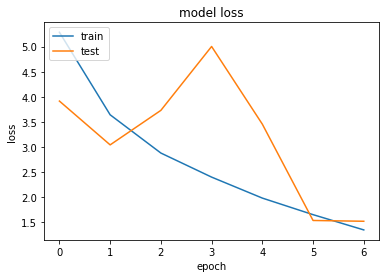

In [24]:
loss(history)

In [9]:
# Model 3 - L2b10 - Best model

modell = Models()
input_shape = (20,96,96, 3)
batch_size = 10
num_epochs = 20

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b10_e20_f20_i96')


# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 96, 96, 8)     32        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 48, 48, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 20, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


67/67 [==============================] - 168s 3s/step - loss: 5.1032 - categorical_accuracy: 0.3348 - val_loss: 4.1101 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-11-0821_40_51.284117/model-00001-5.11135-0.33484-4.11014-0.30000.h5
Epoch 2/20
67/67 [==============================] - 87s 1s/step - loss: 3.5574 - categorical_accuracy: 0.3930 - val_loss: 3.1523 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-11-0821_40_51.284117/model-00002-3.56170-0.39367-3.15235-0.42000.h5
Epoch 3/20
67/67 [==============================] - 89s 1s/step - loss: 2.9084 - categorical_accuracy: 0.4542 - val_loss: 2.9858 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_init_2020-11-0821_40_51.284117/model-00003-2.90839-0.45551-2.98577-0.32000.h5
Epoch 4/20
67/67 [==============================] - 87s 1s/step - loss: 2.4727 - categorical_accuracy: 0.4781 - val_loss: 3.3261 - val_categorical_accuracy: 0.3200

Epoch 00004

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


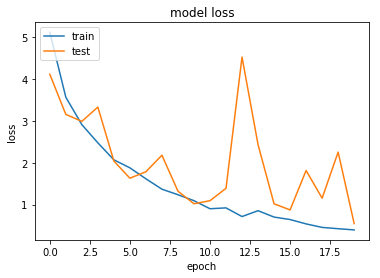

In [13]:
loss(history)

In [9]:
# Model 3 - L2b5f18 - Best model 2

modell = Models()
input_shape = (18,96,96, 3)
batch_size = 5
num_epochs = 15

model = modell.conv_l2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b5_e15_f18_i96')
#loss_plot(history)

# training sequences = 663
# validation sequences = 100
# epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 18, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 96, 96, 8)     32        
_________________________________________________________________
activation_1 (Activation)    (None, 18, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 18, 48, 48, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 18, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 182s 1s/step - loss: 4.9675 - categorical_accuracy: 0.3123 - val_loss: 3.7023 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-11-0821_04_53.497170/model-00001-4.97095-0.31222-3.70225-0.42000.h5
Epoch 2/15
133/133 [==============================] - 80s 603ms/step - loss: 3.2914 - categorical_accuracy: 0.3694 - val_loss: 2.7529 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-11-0821_04_53.497170/model-00002-3.29328-0.36953-2.75290-0.44000.h5
Epoch 3/15
133/133 [==============================] - 80s 601ms/step - loss: 2.6103 - categorical_accuracy: 0.3905 - val_loss: 2.8306 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2020-11-0821_04_53.497170/model-00003-2.61064-0.39065-2.83058-0.23000.h5
Epoch 4/15
133/133 [==============================] - 80s 600ms/step - loss: 2.2172 - categorical_accuracy: 0.4135 - val_loss: 1.7623 - val_categorical_accuracy: 0.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


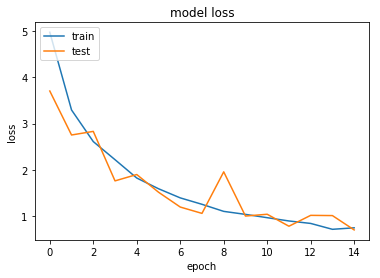

In [15]:

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [28]:
modell = Models()
input_shape = (28,120,120, 3)
batch_size = 20
num_epochs = 25

model = modell.cnn_3(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_l2_b20_e25_f28_i120', optimiser = 'Adam')


# training sequences = 663
# validation sequences = 100
# epochs = 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 28, 120, 120, 8)   648       
_________________________________________________________________
batch_normalization_33 (Batc (None, 28, 120, 120, 8)   32        
_________________________________________________________________
activation_31 (Activation)   (None, 28, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 14, 60, 60, 8)     0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 14, 60, 60, 16)    3456      
_________________________________________________________________
batch_normalization_34 (Batc (None, 14, 60, 60, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


34/34 [==============================] - 119s 3s/step - loss: 1.8881 - categorical_accuracy: 0.2884 - val_loss: 1.7766 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 1.77656, saving model to model_init_2020-11-0911_54_01.189394/model-conv_l2_b20_e25_i120_f28.h5
Epoch 2/25
34/34 [==============================] - 117s 3s/step - loss: 1.3203 - categorical_accuracy: 0.4481 - val_loss: 1.5833 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 1.77656 to 1.58334, saving model to model_init_2020-11-0911_54_01.189394/model-conv_l2_b20_e25_i120_f28.h5
Epoch 3/25
34/34 [==============================] - 106s 3s/step - loss: 1.1667 - categorical_accuracy: 0.4982 - val_loss: 1.3922 - val_categorical_accuracy: 0.4000

Epoch 00003: val_loss improved from 1.58334 to 1.39222, saving model to model_init_2020-11-0911_54_01.189394/model-conv_l2_b20_e25_i120_f28.h5
Epoch 4/25
34/34 [==============================] - 122s 4s/step - loss: 1.0262 - catego

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


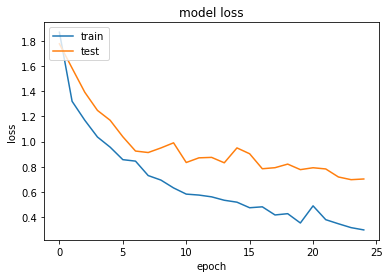

In [29]:
loss(history)

#### Model 4

In [47]:
# Model 4

modell = Models()
input_shape = (18,96,96, 3)
batch_size = 5
num_epochs = 17

model = modell.conv_Increasedl2(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_increasedl2_b5_e17_f18_i96')

# training sequences = 663
# validation sequences = 100
# epochs = 17
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 18, 96, 96, 8)     648       
_________________________________________________________________
batch_normalization_47 (Batc (None, 18, 96, 96, 8)     32        
_________________________________________________________________
activation_49 (Activation)   (None, 18, 96, 96, 8)     0         
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 18, 48, 48, 8)     0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 18, 48, 48, 16)    3456      
_________________________________________________________________
batch_normalization_48 (Batc (None, 18, 48, 48, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 68s 509ms/step - loss: 10.4188 - categorical_accuracy: 0.2732 - val_loss: 5.8348 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-11-0523_18_58.517915/model-00001-10.43102-0.27300-5.83479-0.47000.h5
Epoch 2/17
133/133 [==============================] - 67s 507ms/step - loss: 4.6911 - categorical_accuracy: 0.3554 - val_loss: 3.4912 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-11-0523_18_58.517915/model-00002-4.69464-0.35445-3.49121-0.40000.h5
Epoch 3/17
133/133 [==============================] - 64s 479ms/step - loss: 2.8934 - categorical_accuracy: 0.3719 - val_loss: 2.6015 - val_categorical_accuracy: 0.2700

Epoch 00003: saving model to model_init_2020-11-0523_18_58.517915/model-00003-2.89680-0.37104-2.60149-0.27000.h5
Epoch 4/17
133/133 [==============================] - 62s 466ms/step - loss: 2.0214 - categorical_accuracy: 0.4296 - val_loss: 2.1758 - val_categorical_accuracy

In [28]:
print("Test")

Test


In [46]:
# Model 5 - LSTMGRU - 
 
modell = Models()
input_shape = (18,96,96, 3)
batch_size = 20
num_epochs = 20

model = modell.conv_rnn(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_lstm_b20_e20_f18_i96')
#loss_plot(model)

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_132 (TimeDi (None, 18, 48, 48, 8)     224       
_________________________________________________________________
time_distributed_133 (TimeDi (None, 18, 48, 48, 8)     32        
_________________________________________________________________
time_distributed_134 (TimeDi (None, 18, 24, 24, 8)     0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 18, 24, 24, 8)     0         
_________________________________________________________________
time_distributed_135 (TimeDi (None, 18, 22, 22, 16)    1168      
_________________________________________________________________
time_distributed_136 (TimeDi (None, 18, 22, 22, 16)    64        
_________________________________________________________________
time_d

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


34/34 [==============================] - 69s 2s/step - loss: 3.7514 - categorical_accuracy: 0.2215 - val_loss: 3.5440 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 3.54403, saving model to model_init_2020-11-0813_52_11.508369/model-conv_lstm.h5
Epoch 2/20
34/34 [==============================] - 54s 2s/step - loss: 3.4134 - categorical_accuracy: 0.2848 - val_loss: 3.4221 - val_categorical_accuracy: 0.2500

Epoch 00002: val_loss improved from 3.54403 to 3.42205, saving model to model_init_2020-11-0813_52_11.508369/model-conv_lstm.h5
Epoch 3/20
34/34 [==============================] - 67s 2s/step - loss: 3.0196 - categorical_accuracy: 0.3834 - val_loss: 3.8138 - val_categorical_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 3.42205
Epoch 4/20
34/34 [==============================] - 59s 2s/step - loss: 2.8619 - categorical_accuracy: 0.4128 - val_loss: 2.8714 - val_categorical_accuracy: 0.4400

Epoch 00004: val_loss improved from 3.42205 to 2

In [26]:
# Model 5 - LSTM

modell = Models()
input_shape = (16,96,96, 3)
batch_size = 20
num_epochs = 15

model = modell.conv_lstm(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_lstm_b20_e15_f16_i96')


# training sequences = 663
# validation sequences = 100
# epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 48, 48, 8)     1184      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 46, 46, 8)     584       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 23, 23, 8)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 23, 23, 16)    1168      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 23, 23, 16)    2320      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 11, 11, 16)    0         
_________________________________________________________________
time_d

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


34/34 [==============================] - 89s 3s/step - loss: 1.6106 - categorical_accuracy: 0.1957 - val_loss: 1.5986 - val_categorical_accuracy: 0.3700

Epoch 00001: val_loss improved from inf to 1.59858, saving model to model_init_2020-11-0817_18_38.904592/model-conv_lstm.h5
Epoch 2/15
34/34 [==============================] - 52s 2s/step - loss: 1.4836 - categorical_accuracy: 0.3488 - val_loss: 1.3522 - val_categorical_accuracy: 0.4300

Epoch 00002: val_loss improved from 1.59858 to 1.35225, saving model to model_init_2020-11-0817_18_38.904592/model-conv_lstm.h5
Epoch 3/15
34/34 [==============================] - 55s 2s/step - loss: 1.4319 - categorical_accuracy: 0.3407 - val_loss: 1.5051 - val_categorical_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 1.35225
Epoch 4/15
34/34 [==============================] - 61s 2s/step - loss: 1.3239 - categorical_accuracy: 0.3760 - val_loss: 1.5352 - val_categorical_accuracy: 0.3100

Epoch 00004: val_loss did not improve from 1.352

In [ ]:
# Model 5 - LSTM b20_e30

modell = Models()
input_shape = (18,96,96, 3)
batch_size = 15
num_epochs = 30

model = modell.conv_lstm(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
training(batch_size, num_epochs, model, train_generator, val_generator, name='conv_lstm_b15_e30_f18_i96')


# training sequences = 663
# validation sequences = 100
# epochs = 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 18, 48, 48, 8)     1184      
_________________________________________________________________
time_distributed_41 (TimeDis (None, 18, 46, 46, 8)     584       
_________________________________________________________________
time_distributed_42 (TimeDis (None, 18, 23, 23, 8)     0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 18, 23, 23, 16)    1168      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 18, 23, 23, 16)    2320      
_________________________________________________________________
time_distributed_45 (TimeDis (None, 18, 11, 11, 16)    0         
_________________________________________________________________
time_d

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


45/45 [==============================] - 63s 1s/step - loss: 1.6303 - categorical_accuracy: 0.2028 - val_loss: 1.6125 - val_categorical_accuracy: 0.1900

Epoch 00001: val_loss improved from inf to 1.61252, saving model to model_init_2020-11-0817_42_57.344069/model-conv_lstm_b20_e30.h5
Epoch 2/30
45/45 [==============================] - 62s 1s/step - loss: 1.6153 - categorical_accuracy: 0.2014 - val_loss: 1.6046 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss improved from 1.61252 to 1.60456, saving model to model_init_2020-11-0817_42_57.344069/model-conv_lstm_b20_e30.h5
Epoch 3/30
45/45 [==============================] - 59s 1s/step - loss: 1.6153 - categorical_accuracy: 0.1823 - val_loss: 1.6066 - val_categorical_accuracy: 0.2300

Epoch 00003: val_loss did not improve from 1.60456
Epoch 4/30
45/45 [==============================] - 61s 1s/step - loss: 1.6121 - categorical_accuracy: 0.1897 - val_loss: 1.6088 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not im

#### Model CNN_3

In [29]:
modell = Models()
input_shape = (16,120,120, 3)
batch_size = 20
num_epochs = 20

model = modell.cnn_3(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_3_b20_e20_i120_f16', optimiser = 'Adam')


# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 16, 120, 120, 8)   648       
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
activation_27 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 8, 60, 60, 16)     3456      
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 60, 60, 16)     64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


34/34 [==============================] - 77s 2s/step - loss: 1.7865 - categorical_accuracy: 0.3319 - val_loss: 1.6104 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-11-0822_29_05.871424/model-00001-1.78884-0.33183-1.61035-0.43000.h5
Epoch 2/20
34/34 [==============================] - 58s 2s/step - loss: 1.4232 - categorical_accuracy: 0.4636 - val_loss: 1.2298 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2020-11-0822_29_05.871424/model-00002-1.44131-0.45852-1.22982-0.49000.h5
Epoch 3/20
34/34 [==============================] - 68s 2s/step - loss: 1.2047 - categorical_accuracy: 0.5129 - val_loss: 1.1814 - val_categorical_accuracy: 0.4800

Epoch 00003: saving model to model_init_2020-11-0822_29_05.871424/model-00003-1.18338-0.51735-1.18141-0.48000.h5
Epoch 4/20
34/34 [==============================] - 71s 2s/step - loss: 0.9624 - categorical_accuracy: 0.6247 - val_loss: 0.9807 - val_categorical_accuracy: 0.6600

Epoch 00004:

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


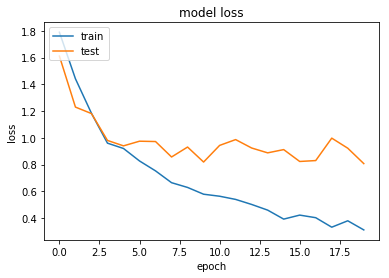

In [30]:
loss(history)

In [25]:
modell = Models()
input_shape = (28,120,120, 3)
batch_size = 20
num_epochs = 15

model = modell.cnn_3(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_3_b20_e15_i120_f28', optimiser = 'Adam')


# training sequences = 663
# validation sequences = 100
# epochs = 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 28, 120, 120, 8)   648       
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 120, 120, 8)   32        
_________________________________________________________________
activation_23 (Activation)   (None, 28, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 14, 60, 60, 8)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 14, 60, 60, 16)    3456      
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 60, 60, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


34/34 [==============================] - 121s 4s/step - loss: 2.0130 - categorical_accuracy: 0.2855 - val_loss: 1.6080 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 1.60803, saving model to model_init_2020-11-0911_21_06.758129/model-conv_l2_b20_e15_i120_f28.h5
Epoch 2/15
34/34 [==============================] - 120s 4s/step - loss: 1.3890 - categorical_accuracy: 0.4467 - val_loss: 1.4969 - val_categorical_accuracy: 0.4000

Epoch 00002: val_loss improved from 1.60803 to 1.49693, saving model to model_init_2020-11-0911_21_06.758129/model-conv_l2_b20_e15_i120_f28.h5
Epoch 3/15
34/34 [==============================] - 110s 3s/step - loss: 1.3015 - categorical_accuracy: 0.5033 - val_loss: 1.2114 - val_categorical_accuracy: 0.5500

Epoch 00003: val_loss improved from 1.49693 to 1.21141, saving model to model_init_2020-11-0911_21_06.758129/model-conv_l2_b20_e15_i120_f28.h5
Epoch 4/15
34/34 [==============================] - 109s 3s/step - loss: 1.0608 - catego

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


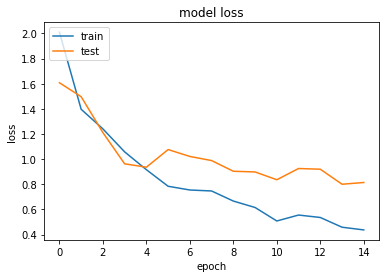

In [26]:
loss(history)

In [28]:
modell = Models()
input_shape = (28,120,120, 3)
batch_size = 20
num_epochs = 25

model = modell.cnn_3(input_shape)

train_generator = generator(train_path, train_doc, batch_size, input_shape[0],input_shape[1], input_shape[2]) 
val_generator = generator(val_path, val_doc, batch_size,input_shape[0], input_shape[1], input_shape[2])
history = training(batch_size, num_epochs, model, train_generator, val_generator, name='cnn_3_b20_e25_i120_f28', optimiser = 'Adam')


# training sequences = 663
# validation sequences = 100
# epochs = 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 28, 120, 120, 8)   648       
_________________________________________________________________
batch_normalization_33 (Batc (None, 28, 120, 120, 8)   32        
_________________________________________________________________
activation_31 (Activation)   (None, 28, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 14, 60, 60, 8)     0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 14, 60, 60, 16)    3456      
_________________________________________________________________
batch_normalization_34 (Batc (None, 14, 60, 60, 16)    64        
_________________________________________________________________
activa

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


34/34 [==============================] - 119s 3s/step - loss: 1.8881 - categorical_accuracy: 0.2884 - val_loss: 1.7766 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 1.77656, saving model to model_init_2020-11-0911_54_01.189394/model-conv_l2_b20_e25_i120_f28.h5
Epoch 2/25
34/34 [==============================] - 117s 3s/step - loss: 1.3203 - categorical_accuracy: 0.4481 - val_loss: 1.5833 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 1.77656 to 1.58334, saving model to model_init_2020-11-0911_54_01.189394/model-conv_l2_b20_e25_i120_f28.h5
Epoch 3/25
34/34 [==============================] - 106s 3s/step - loss: 1.1667 - categorical_accuracy: 0.4982 - val_loss: 1.3922 - val_categorical_accuracy: 0.4000

Epoch 00003: val_loss improved from 1.58334 to 1.39222, saving model to model_init_2020-11-0911_54_01.189394/model-conv_l2_b20_e25_i120_f28.h5
Epoch 4/25
34/34 [==============================] - 122s 4s/step - loss: 1.0262 - catego

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


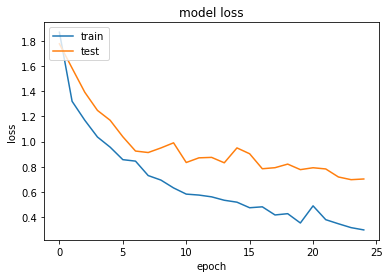

In [29]:
loss(history)